<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw2_clustering/hw_clustering_ski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/Shared drives/machine learning"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hw_clustering_ski.ipynb  hw_test_set.csv  hw_train_set.csv


Feature description: <br />
ambient	: Ambient temperature <br />
coolant : Coolant temperature <br />
u_d : Voltage d-component <br />
u_q	: Voltage q-component
motor_speed : Motor speed <br />
torque : Torque induced by current <br />
i_d : Current d-component <br />
i_q : Current q-component <br />
pm : Permanent Magnet surface temperature <br />
stator_yoke	: Stator yoke temperature <br />
stator_tooth : Stator tooth temperature <br />
stator_winding : Stator winding temperature <br />
profile_id : Distinctive session ID <br />
<br />


In [4]:
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split


train_dataset = '/content/drive/Shared drives/machine learning/hw_train_set.csv'
df_main = pd.read_csv(train_dataset)
df_main.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


The task is to design a model with appropriate feature engineering, that estimates four target temperatures (pm stator_yoke stator_tooth stator_winding) in a causal manner <br />
There are about 840,000 records, which could cause colab crash, so we select a fraction 1% of it, which means around 8400 records for analysis

In [9]:
target_feature_list = ['pm', 'stator_yoke', 'stator_tooth', 'stator_winding']

df_cluster = df_main[target_feature_list].sample(frac=0.01)

Feature importance and selection
First, take a look at the data distribution

[dtype('float64'), dtype('int64')]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbce65d36a0>,
      dtype=object)

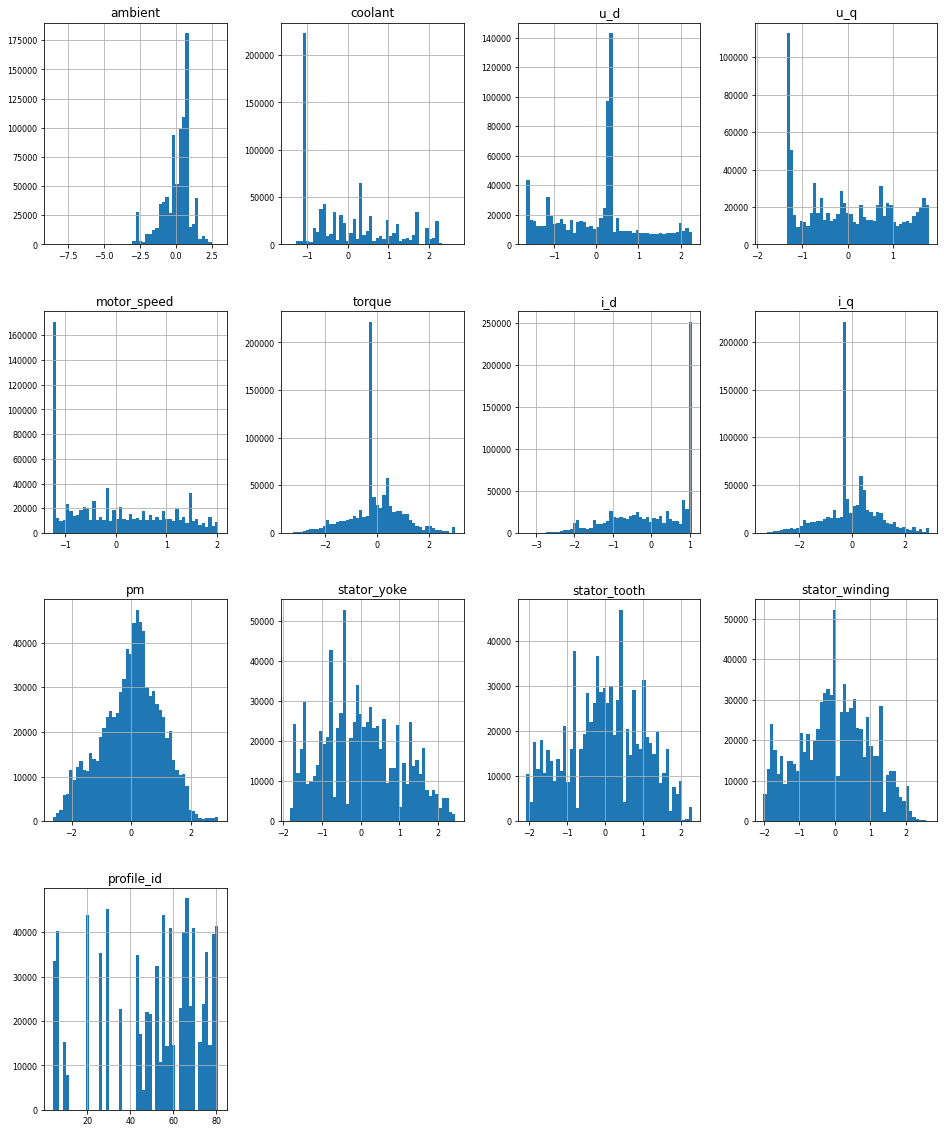

In [10]:
print(list(set(df_main.dtypes.tolist())))
df_num = df_main.select_dtypes(include=['float64', 'int64'])
df_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8)

Use correlation to see feature importance, gini score seems suitible for discrete valuse and not suitable for continuous values like this one.

In [11]:
X = df_main.drop(columns=['pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'profile_id'])

for feature in target_feature_list:
  X[feature] = df_main[feature]
  df_num_corr = X.corr()[feature]
  golden_features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=True)
  print("There is {} correlated values with feature {}:\n{}"
        .format(len(golden_features_list), feature, golden_features_list))
  X = X.drop(columns=[feature])

There is 7 correlated values with feature pm:
i_d           -0.291318
i_q           -0.111800
u_q            0.110613
motor_speed    0.334227
coolant        0.451611
ambient        0.558549
pm             1.000000
Name: pm, dtype: float64
There is 8 correlated values with feature stator_yoke:
i_d           -0.183370
i_q           -0.116177
torque        -0.108841
u_q            0.113901
motor_speed    0.193406
ambient        0.465432
coolant        0.882167
stator_yoke    1.000000
Name: stator_yoke, dtype: float64
There is 6 correlated values with feature stator_tooth:
i_d            -0.382091
u_q             0.159463
motor_speed     0.337127
ambient         0.430322
coolant         0.707196
stator_tooth    1.000000
Name: stator_tooth, dtype: float64
There is 7 correlated values with feature stator_winding:
i_d              -0.531083
u_d              -0.127975
u_q               0.138465
ambient           0.344476
motor_speed       0.392176
coolant           0.531963
stator_winding    1

Where we can see <br />
Coolant motor_speed ambient i_d are most important features correlated to target features, profile_id is least correlated

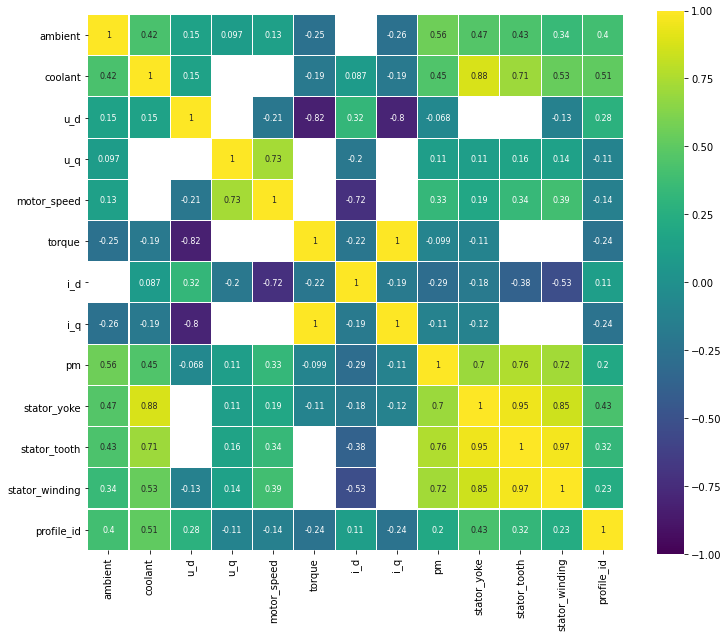

In [12]:
# Features correlations
#
# We already examined AcresBurned correlations
# We use heatmap to better understand correlations among features
# Shown with the abslute correlation > 0.06
corr = df_main.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.06) | (corr <= -0.06)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Use elbow method to determine cluster number N <br />

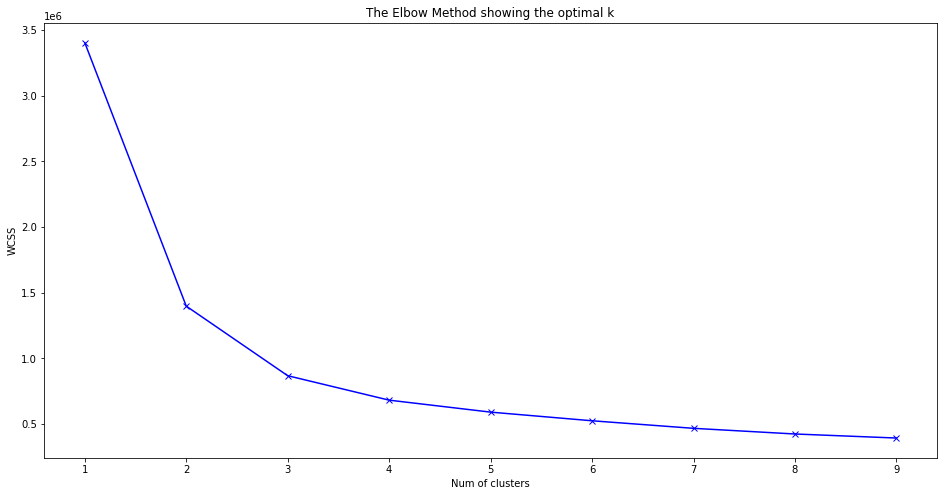

In [9]:
from sklearn.cluster import KMeans

wcss = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeanModel.fit(df_cluster)
    wcss.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, wcss, 'bx-')
plt.xlabel('Num of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From elblow methos, we use cluster number N=3. <br />
Use Spectral clusting:

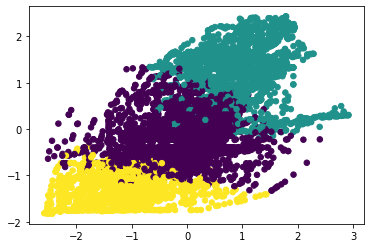

In [13]:
from sklearn.cluster import SpectralClustering

X = df_cluster.to_numpy()

spc_cluster = SpectralClustering(n_clusters=3,
         assign_labels="discretize",
         random_state=0)
spc_cluster.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=spc_cluster.labels_, s=30, cmap='viridis')
plt.show()

Use KMean clustering:

In [15]:
from sklearn.cluster import KMeans

n_clusters = 3
X = df_cluster.to_numpy()
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

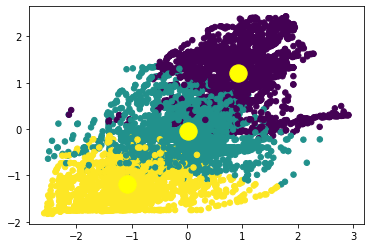

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.show()

Use Gaussian Mixture clustering:

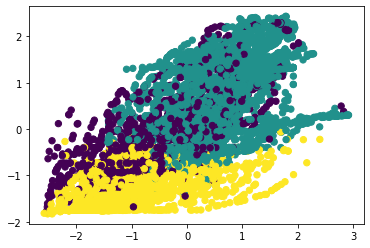

In [27]:
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=3).fit(X)
gmm_labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, s=40, cmap='viridis')

Use Birch clustering

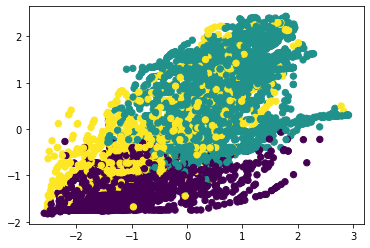

In [24]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=3).fit(X)
brc_labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=brc_labels, s=40, cmap='viridis')

Use Agglomerative Clustering

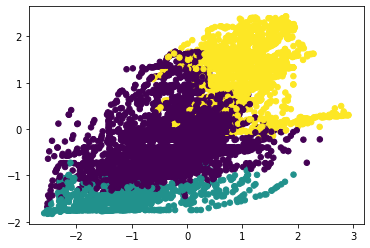

In [32]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)
plt.scatter(X[:, 0], X[:, 1], c=agg.labels_, s=30, cmap='viridis')

We can see KMeans and Spectral have similar clustering results, and Gaussian and Birch have similar clustering results on our dataset.

In [33]:
df_cluster['y_kmean'] = kmeans.labels_
df_cluster['y_gmm'] = gmm_labels
df_cluster['y_spec'] = spc_cluster.labels_
df_cluster['y_agg'] = agg.labels_
df_cluster.sample(n=30)

,pm,stator_yoke,stator_tooth,stator_winding,y_kmean,y_gmm,y_spec,y_agg
596310,1.001015,1.277179,1.112756,0.964818,0,1,1,2
284367,0.500292,1.611072,1.174483,0.759440,0,1,1,2
65624,-0.364210,-1.027558,-1.041350,-1.065076,2,2,2,0
695075,0.164539,-0.019848,-0.387077,-0.626184,1,0,0,0
298085,1.827088,2.294058,1.991620,1.729591,0,1,1,2
640911,-0.068100,-0.043703,-0.162590,-0.179615,1,0,0,0
810284,0.431018,0.575840,0.692943,0.813524,0,1,1,2
141783,-2.041634,-0.734724,-0.524134,-0.314359,2,2,2,0
624004,0.310900,0.613897,0.579927,0.457713,1,1,0,0
128061,0.001794,0.870194,0.632711,0.408699,1,1,0,0


What the clustering results represent, take KMean for example: <br />
Cluster 0 represents the high tempratures <br />
Cluster 1 represents the medium tempratures <br />
Cluster 2 represents the low tempratures <br />
<br />

Gaussian and Birch clustering results cannot reprent this, so they should not be used in this dataset clutering.